**Feature Extraction from the dataset**

In [2]:
import pandas as pd
import re
from urllib.parse import urlparse
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
common_short_url = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'ow.ly', 'buff.ly', 'is.gd', 'adf.ly', 'sniply.io', 'dub.co', 'short.io', 'ZipZy.in']

def calculate_entropy(s):
    probs = [freq / len(s) for freq in Counter(s).values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

def extract_url_features(url):
    parsed = urlparse(url)
    domain = parsed.netloc
    path = parsed.path
    
    unsafe_chars = set(' "<>#%{}|\\^[]~`')
    suspicious_words = {"login", "secure", "verify", "bank", "auth", "account", "update", "confirm", "signin", "wp-login", "validate", "submit"}
    return {
        "url_len": len(url),
        "num_unsafe_chars": sum(1 for char in url if char in unsafe_chars),
        "num_digits": sum(c.isdigit() for c in url),
        "num_subdomains": domain.count('.'),
        "is_ip": bool(re.match(r'\d+\.\d+\.\d+\.\d+', domain)), 
        "num_params": url.count('?'),
        "num_slashes": url.count('/'),    #directory depth and obfuscation
        "contains_suspicious_keywords": any(word in url.lower() for word in suspicious_words),
        "contains_suspicious_file_extension": any(ext in path.lower() for ext in ['.exe', '.zip', '.js', '.php']),
        "short_url": any(short in domain for short in common_short_url),  
        "url_entropy": calculate_entropy(url),
        "has_https": url.startswith("https")
    }

df = pd.read_csv("dataset\kaggle_malicious_url.csv")
features_df = pd.DataFrame(df["url"].apply(extract_url_features).tolist())


#tf-idf feature
def preprocess_url(url):
    """Extract words from URL (remove special characters and split by delimiters)."""
    url = re.sub(r"https?://", "", url) 
    url = re.sub(r"[^a-zA-Z0-9]", " ", url)  
    return url.lower()

df["processed_url"] = df["url"].apply(preprocess_url)

vectorizer = TfidfVectorizer(max_features=500) 
tfidf_matrix = vectorizer.fit_transform(df["processed_url"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df["tfidf_score"] = tfidf_df.sum(axis=1)
df = pd.concat([df, features_df], axis=1)

df.to_csv("processed_dataset.csv", index=False)
print("Feature extraction completed and saved.")

Feature extraction completed and saved.


In [4]:
import joblib
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')

['models/tfidf_vectorizer.pkl']

In [5]:
df

,url,type,processed_url,tfidf_score,url_len,num_unsafe_chars,num_digits,num_subdomains,is_ip,num_params,num_slashes,contains_suspicious_keywords,contains_suspicious_file_extension,short_url,url_entropy,has_https
0,br-icloud.com.br,phishing,br icloud com br,1.121511,16,0,0,0,False,0,0,False,False,False,3.375000,False
1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid com music krizz kaliko html,1.506488,35,0,1,0,False,0,2,False,False,False,4.079143,False
2,bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets org rexroth cr 1 htm,1.411674,31,0,1,0,False,0,3,False,False,False,3.708093,False
3,http://www.garage-pirenne.be/index.php?option=...,defacement,www garage pirenne be index php option com con...,3.125496,88,0,7,2,False,1,3,False,True,False,4.660343,False
4,http://adventure-nicaragua.net/index.php?optio...,defacement,adventure nicaragua net index php option com m...,2.832781,235,0,22,1,False,1,3,False,True,False,5.491293,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,benign,xbox360 ign com objects 850 850402 html,1.342050,39,0,12,0,False,0,3,False,False,False,4.355539,False
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,benign,games teamxbox com xbox 360 1860 dead space,1.173645,44,0,7,0,False,0,4,False,False,False,4.243300,False
651188,www.gamespot.com/xbox360/action/deadspace/,benign,www gamespot com xbox360 action deadspace,1.450187,42,0,3,0,False,0,4,False,False,False,4.147921,False
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),benign,en wikipedia org wiki dead space video game,2.386594,45,0,0,0,False,0,2,False,False,False,4.102313,False


**Evaluating Feature Correlation**

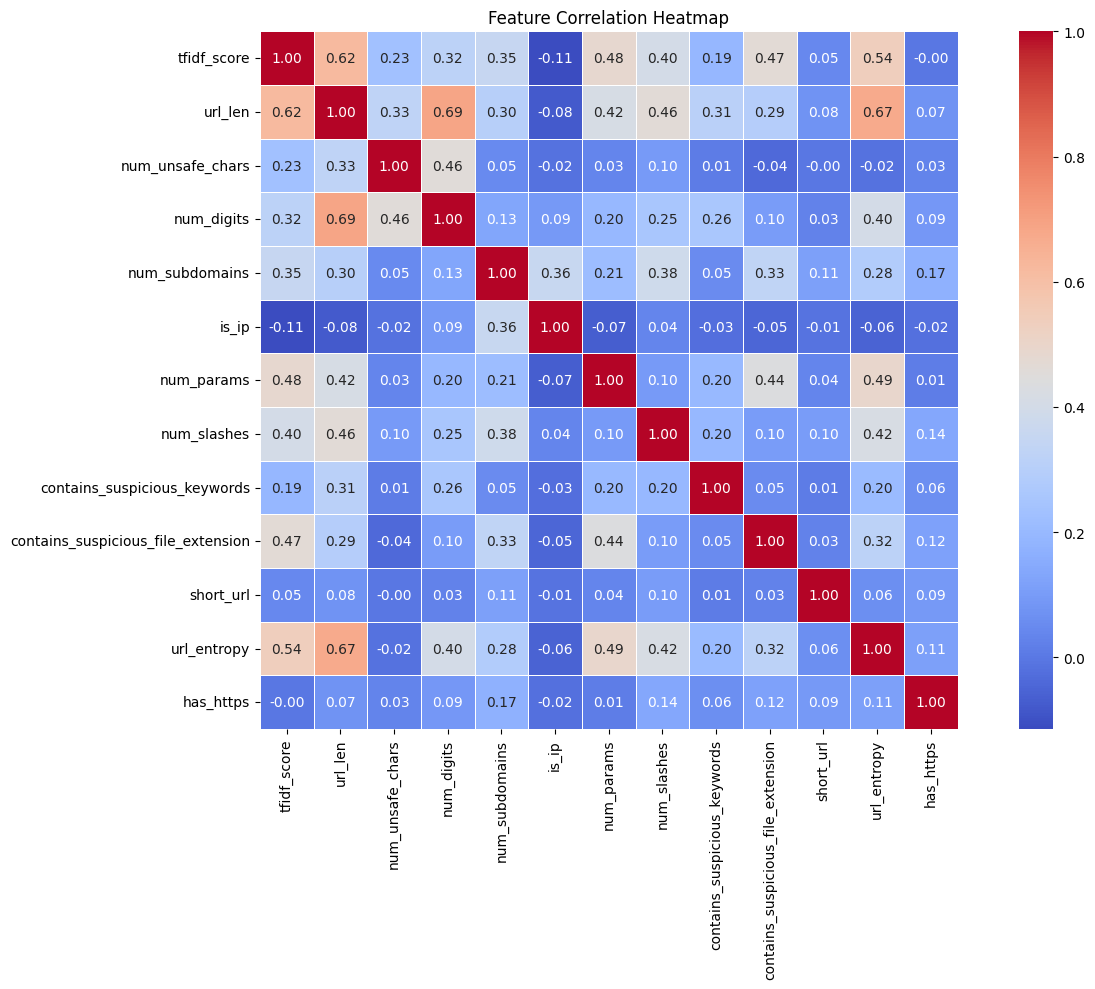

In [9]:
features = pd.read_csv("processed_dataset.csv")
corr_matrix = features.corr(numeric_only=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
